In [1]:
import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt

pathData     = '/Users/benjamin/DVPT/EEG/Data/AllSubjects_events_collision/'
pathData     = '/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/AllSubjects_events_collision/'
eventFiles   = glob.glob(pathData+"*_event*")
noEventFiles = glob.glob(pathData+"*_noevent*")

nEvent       = len (eventFiles)
nNoEvent     = len (noEventFiles)
nSample      = nEvent + nNoEvent
nChannels    = 59
nTimeStep    = 320

In [2]:
nEvent

683

In [2]:
signalEvent   = np.zeros ( (nEvent  , nChannels, nTimeStep), dtype=float)
signalNoEvent = np.zeros ( (nNoEvent, nChannels, nTimeStep), dtype=float)

for i in range (nEvent):
    signalEvent[i]   = np.load (eventFiles  [i])[:,-nTimeStep::]
for i in range (nNoEvent):
    signalNoEvent[i] = np.load (noEventFiles[i])[:,-nTimeStep::]
       
signals  = np.concatenate((signalEvent, signalNoEvent))
mu       = np.mean (signals, axis=0)
signalsC = signals - mu

mu1  = np.mean (signalEvent  , axis=0)
mu2  = np.mean (signalNoEvent, axis=0)

* Creation du maillage Saptio-temporel

In [3]:
file_name ='/Users/benjamin/DVPT/EEG/Data/VPja.mat'
file_name ='/Users/obando_c/Documents/Neuro/EmergencyBraking/data/raw/VPja.mat'
with h5py.File(file_name, 'r') as f:
    mnt = f.get('mnt')
    pos3d_allChannels = np.array(mnt.get('pos_3d')) 

pos3d_eegChannels = pos3d_allChannels[np.delete(np.arange(61), [0, 5])]

spatiotemp_mesh = []
for p in pos3d_eegChannels[:nChannels]: 
    xi, yi, zi = tuple(p)
    for ti in range(nTimeStep):
        spatiotemp_mesh.append([xi, yi, zi, ti])

* KL decomposition sur tous les Signaux 

In [4]:
# import openturns as ot
# dim_ch_in  = 1 
# dim_ch_out = 1 
# process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
# for k in range(process_sample.getSize()):
#     process_sample[k] = signalsC[k].reshape(-1,1) # This doesn't work with my version of openturns
# 
# s    = 0.0 
# w_v  = np.ones(nChannels*nTimeStep) 
# algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) 
# algo.run()

# fPCA     = algo.getResult()

import openturns as ot
dim_ch_in  = 1 
dim_ch_out = 1 
process_sample = ot.ProcessSample(ot.Mesh(spatiotemp_mesh), nSample, dim_ch_in) 
field          = ot.Field(ot.Mesh(spatiotemp_mesh), dim_ch_out) 
for k in range(process_sample.getSize()):
    field.setValues(signalsC[k].reshape(-1,1))
    process_sample[k] = field

s    = 0.0 
w_v  = np.ones(nChannels*nTimeStep) 
algo = ot.KarhunenLoeveSVDAlgorithm(process_sample,w_v, s) 
algo.run()

fPCA     = algo.getResult()

* Controle de la qualité de la décomposition

In [5]:
vp       = fPCA.getEigenValues()
Phi      = fPCA.getModes()
Xi       = np.array(fPCA.project(process_sample))
XiLambda = Xi * ot.Point([np.sqrt(x) for x in vp])
T        = np.array([t for t in spatiotemp_mesh])
V_app    = ot.DualLinearCombinationFunction(fPCA.getModes(), np.array(XiLambda).T) 

In [71]:
pos3d_eegChannels.shape

(59, 3)

In [75]:
mode_0.shape

(59, 320)

In [68]:
from PIL import Image
import glob
 
# Create the frames
frames = []
pathimgs = '/Users/obando_c/Documents/Neuro/EmergencyBraking/notebooks/Plots/map_mode0/'
imgs = glob.glob(pathimgs+"*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save(pathimgs+'png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

Résidu Max sur l'echantillon:      1.4370726830748026e-11
Ratio Valeur Propre 1/50:           0.0013730560066998743
Pourcentage de variance au mode 50: 0.9441231924741181


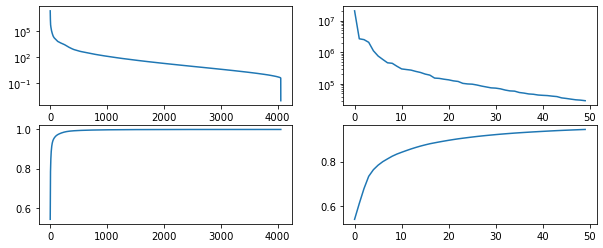

In [7]:
RandIdx = np.random.randint (0, process_sample.getSize()-1, 50 ).tolist()
Residu  = np.array ([V_app.getMarginal(k)(T) for k in RandIdx])
Residu -= np.array ([process_sample[k]for k in RandIdx])

pVar    = np.cumsum(vp) / np.sum(vp)
fig, ax = plt.subplots(2,2, figsize=(10,4))

ax[0,0].semilogy(vp)  ; ax[0,1].semilogy(vp[0:50])
ax[1,0].plot    (pVar); ax[1,1].plot    (pVar[0:50])
print ('Résidu Max sur l\'echantillon:     ', np.max(Residu))
print ('Ratio Valeur Propre 1/50:          ', vp[50]/vp[0])
print ('Pourcentage de variance au mode 50:', pVar[49])

* Effet de la troncature

Mode Max   max erreur moy   max erreur max   valeur max      
    10         7.75e-01         2.47e+02         2.43e+02    
    20         7.28e-01         2.47e+02         2.43e+02    
    40         6.04e-01         2.37e+02         2.43e+02    
    80         5.38e-01         2.31e+02         2.43e+02    
   150         4.56e-01         2.11e+02         2.43e+02    
   300         3.45e-01         1.57e+02         2.43e+02    
   600         1.47e-01         4.71e+01         2.43e+02    
   1200        6.49e-02         1.94e+01         2.43e+02    
   2400        2.33e-02         4.63e+00         2.43e+02    
   3500        9.17e-03         1.37e+00         2.43e+02    
   3800        4.97e-03         5.92e-01         2.43e+02    
   4000        2.07e-03         2.76e-01         2.43e+02    
   4025        1.46e-03         1.82e-01         2.43e+02    
   4050        4.83e-04         5.73e-02         2.43e+02    
   4054        3.24e-04         4.31e-02         2.43e+02    
   4056 

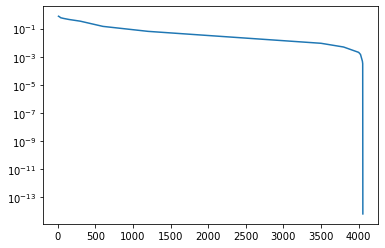

In [8]:
RandIdx = np.random.randint (0, process_sample.getSize()-1, 15 ).tolist()
modes   = fPCA.getModes()
Residus = []
Y       = np.array ([process_sample[k]for k in RandIdx])
rangeModes = [10, 20 , 40 , 80, 150, 300, 600, 1200, 2400, 3500, 3800, 4000, 4025, 4050, 4054,4056]
print ('{:10}'.format('Mode Max'),'{:16}'.format( 'max erreur moy'), '{:16}'.format( 'max erreur max'), '{:16}'.format( 'valeur max'))

for k in rangeModes:
    subXiLambda = XiLambda[:, 0:k ]
    subModes    = [modes[i] for i in range (k)]


    V_app       = ot.DualLinearCombinationFunction(subModes, np.array(subXiLambda).T)
    Residu      = np.array ([V_app.getMarginal(idx)(T) for idx in RandIdx])
    Residu     -= Y
    res         = np.max(np.linalg.norm(Residu, axis=1))
    resMax      = np.max (Residu)
    Residus.append(res/4056)
    print ('{:^10}'.format(k), '{:^16.2e}'.format(res/4056), '{:^16.2e}'.format(resMax), '{:^16.2e}'.format(np.max(Y)))
    
plt.semilogy (np.array (rangeModes),np.array (Residus))

* Analyse par cluster (Event / NoEvent)

In [9]:
XiEvent   = Xi[0:len(eventFiles)]
XiNoEvent = Xi[len(eventFiles):nSample-1]



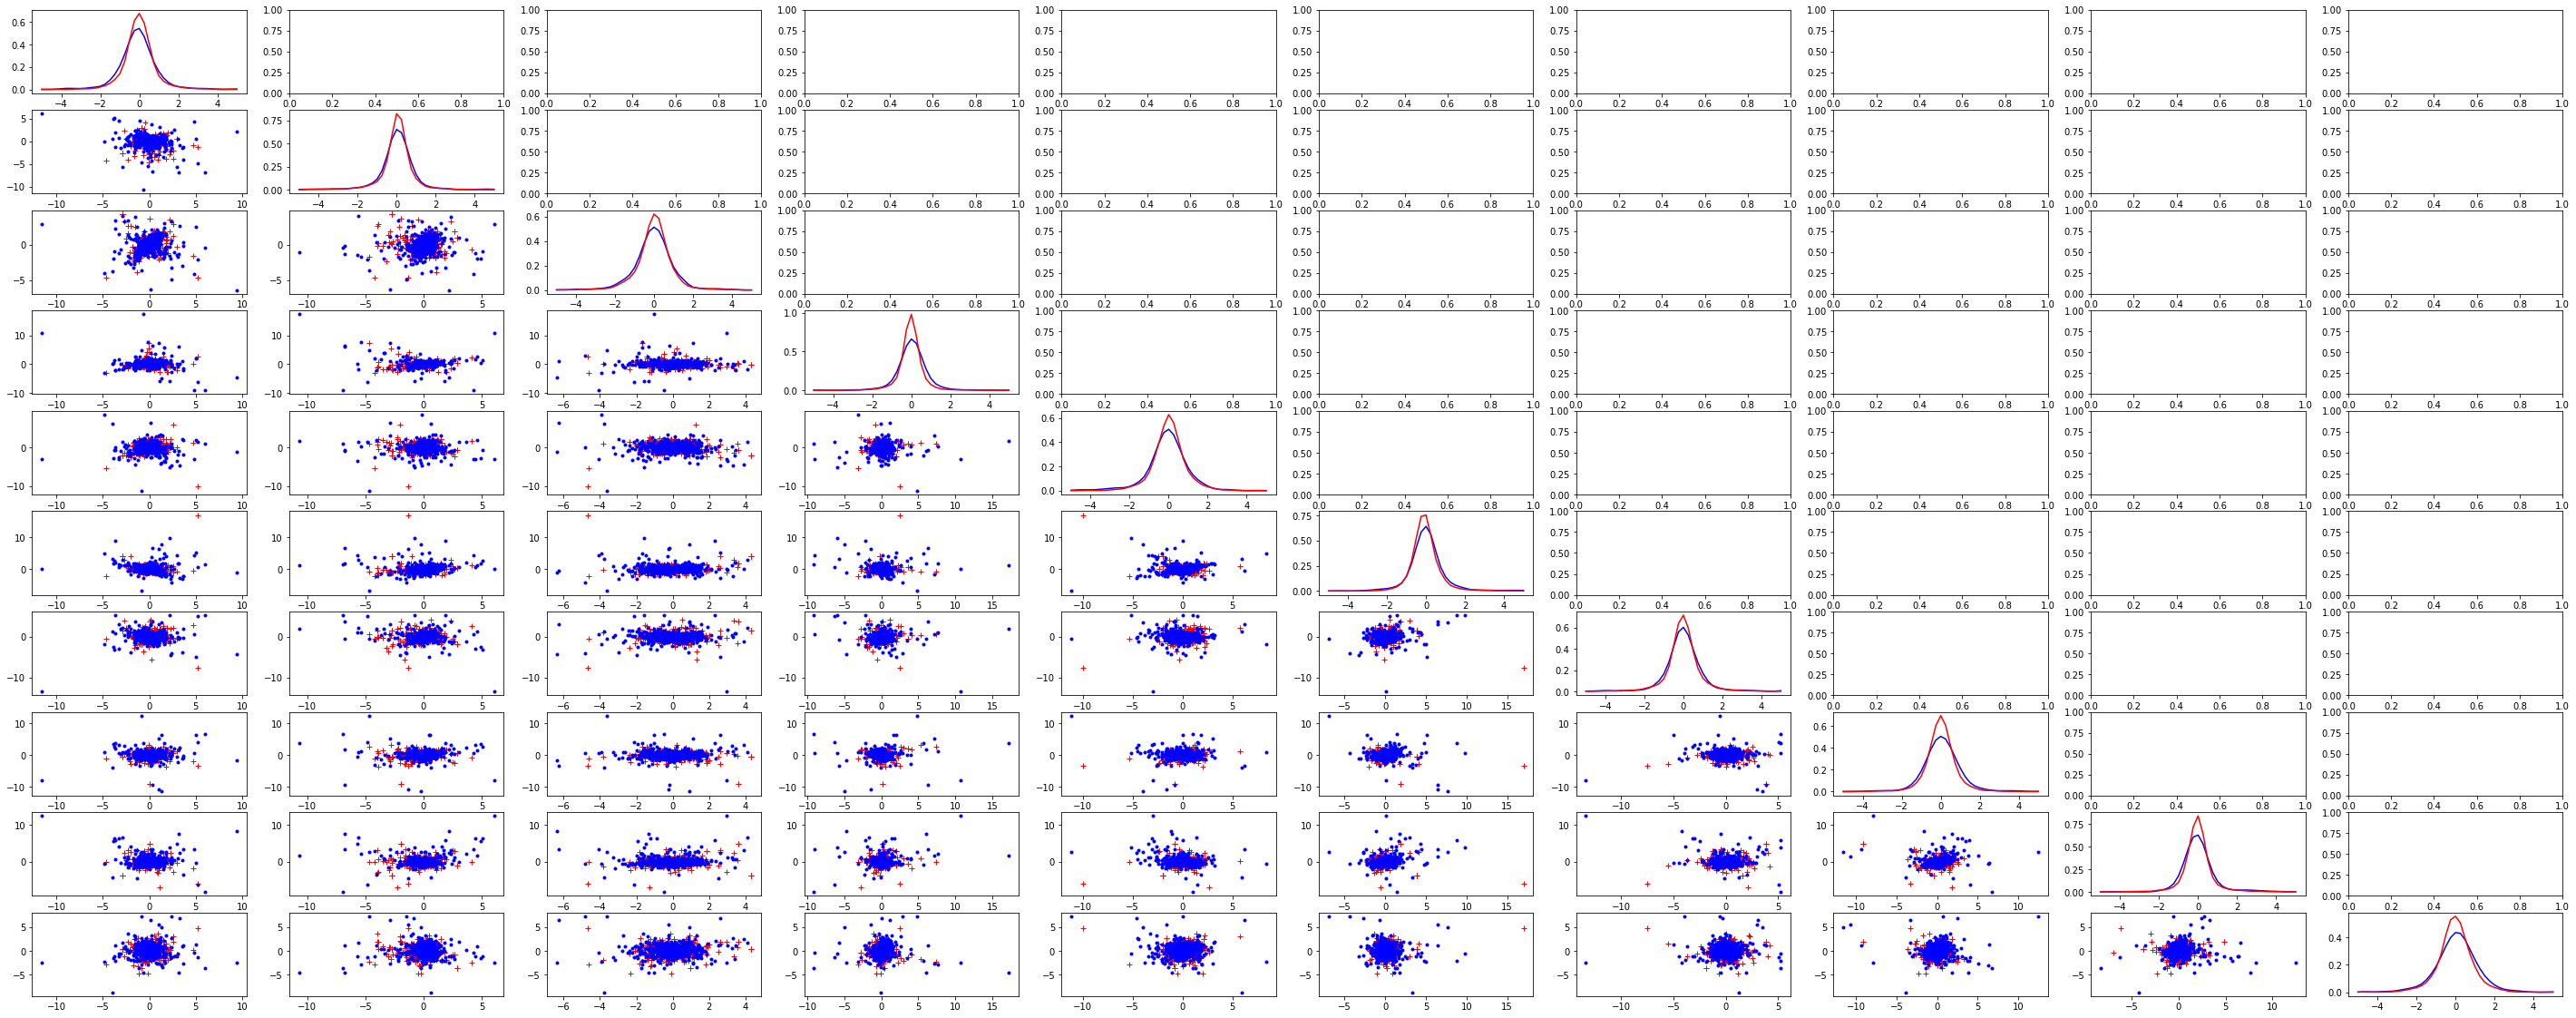

In [10]:
from scipy.stats.kde import gaussian_kde

minMode = 10
nbModes = 10

marginalEvent    = [gaussian_kde(XiEvent  [:,k]) for k in range (minMode, minMode+nbModes)]
marginalNoEvent  = [gaussian_kde(XiNoEvent[:,k]) for k in range (minMode, minMode+nbModes)]

fig, ax = plt.subplots(nbModes,nbModes, figsize=(50,20))
x       = np.linspace(-5, 5.0, 41)

for k in range (0, nbModes):
    ax[k,k].plot (x, [marginalEvent  [k](i) for i in x], "b")
    ax[k,k].plot (x, [marginalNoEvent[k](i) for i in x], "r")

RandIdx = np.random.randint (0, len(XiNoEvent)-1, len(XiEvent)).tolist()
XiNoEvt = np.array([XiNoEvent[k,:] for k in RandIdx])
for k in range (minMode,minMode+nbModes):
    ik = k - minMode
    for j in range (minMode, k):
        ij = j - minMode
        ax[ik,ij].plot (XiNoEvt[:,j], XiNoEvt[:,k],'r+')
        ax[ik,ij].plot (XiEvent[:,j], XiEvent[:,k],'b.')


In [11]:
from sklearn import svm
import random

In [12]:
Y=np.concatenate ([np.array(len(eventFiles)*[1]), np.array(len(noEventFiles)*[0])])

In [13]:
trainEvent   = random.sample (range(0              , len(eventFiles)), 400 )
trainNoEvent = random.sample (range(len(eventFiles), Y.shape[0]     ), 400 )

notInTrainE = np.array ([k for k in range (0              , len(eventFiles)) if k not in trainEvent  ])
notInTrainN = np.array ([k for k in range (len(eventFiles), Y.shape[0]     ) if k not in trainNoEvent])

train       = np.concatenate ([trainEvent, trainNoEvent])
test        = np.concatenate ([notInTrainE, notInTrainN[0:notInTrainE.shape[0]]])

Xitrain     = Xi [train]
Xitest      = Xi [test]
Ytrain      = Y  [train]
Ytest       = Y  [test]                               

In [14]:
clf = svm.SVC()

In [15]:
accuracy = []
for k in [1, 2, 5, 10, 50, 100, 200, 500, 1000]:
    clf.fit (Xitrain[:,0:k], Ytrain)
    Ypred = clf.predict(Xitest[0:2*notInTrainE.shape[0],0:k])
    Res = Ytest - Ypred
    accuracy.append(1. - np.mean(Res))

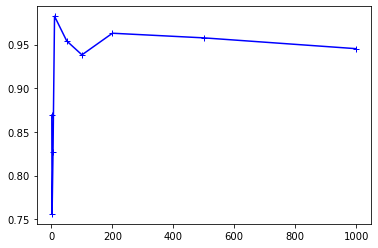

In [16]:
plt.plot ([1, 2, 5, 10, 50, 100, 200, 500, 1000], accuracy, 'b+-')

In [21]:
Xitrain.shape

(800, 4056)

In [31]:
Xi.shape[0]

4057

## <font color='blue'> Export data </font>

In [42]:
import os
nModes = 500
#nChannels = 59
path_data_save = os.path.normpath(os.path.join('/Users/obando_c/Documents/Neuro/EmergencyBraking/data/post_processed/nModes'+ str(nModes)))
labels = np.zeros(nSample)
labels[:len(eventFiles)] = 1
test_id = "na"

for event_index in range(Xi.shape[0]):
    x = np.asarray(Xi [event_index,:500]).reshape(1,500)
    if(labels[event_index] == 0):
        path_out = os.path.join(path_data_save, '%s_segment_%d_noevent.npy' % (event_index, int(labels[event_index])))
    else:
        path_out = os.path.join(path_data_save, '%s_segment_%d_event.npy' % (event_index, int(labels[event_index])))
    np.save(path_out, x)

In [43]:
len(eventFiles)

683

In [22]:
Xi.shape

(4057, 4056)

In [17]:
Res = Ytest - Ypred

In [18]:
print (1. - np.mean(Res))

0.9858657243816255
